Runs simulations for FPT for cliques with partially spatially correlated noise and homogeneous drift (drift here = 1).

In [1]:
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
import scipy.io as sio
import statistics as st
import time as ticky
import multiprocessing as mp

from numba import jit, njit, prange


## Homogeneous FPT

Set parameters:

In [7]:
theta = .5
c_array = (0,.1,.25,.5,.75,.9,1)
n_array = (10,50,100,500,1000)
numTrials = 1500
# theta is the size of the threshold
# c is the correlation parameter
# n is the size of the clique

In [25]:
def getDt(th,n):
    expectedTime = th**2/(4*np.log(n))
    
    return expectedTime/250

Generate the data specified in parameters


In [3]:
@jit(nopython = True,parallel = True)



# Code to run a single trial
def oneRun (n,c,th,dt,mult,multCom,multNonCom):
    
    nInt = int(n)
    x = np.zeros(nInt);
    
    runTime = 0.0

    while np.abs(x).max() < th:
        common = multCom*np.random.normal()*np.ones(nInt)
        nonCommon = np.random.normal(loc = 0.0, scale = 1.0,size = nInt)
        x = x + dt*np.ones(nInt) + common*mult  + nonCommon*mult*multNonCom

        runTime = runTime + dt

    return runTime


@njit(parallel = True)
# Code to run a batch of trials (numTrials worth)
def oneBatch(n=5,c=.1,th=.1,numTrials = 100):
    
    # Choose the timestep as a function of the expected time
    if n == 1: dt = .00001
    else:  dt = (th**2/(4*np.log(n)))/250
    
    # Only calculate constants once... 
    mult = np.sqrt(2*dt); multCom = np.sqrt(c); multNonCom = np.sqrt(1-c)
    
    times = np.zeros(numTrials)
    for i in prange(numTrials):
        
        runTime = oneRun(float(n),c,th,dt,mult,multCom,multNonCom)
        times[i] = runTime #accs.append(FD)

    
    
    return(np.sum(times)/numTrials,times)

In [5]:
# Generate data
tic1 = ticky.perf_counter()

timesForC = []; timeHistsForC = []
for c in c_array:
    print("Starting c = " + str(c))
    
    tic = ticky.perf_counter()
    if c == 1:
        timesVsN = np.ones(len(n_array)) * oneBatch(1,1,theta,numTrials)[0]
        timesForC.append(timesVsN);
    else:
        
        timesVsN = [];  timeHistsVsN = []; 
        
        for n in n_array:
            time, times = oneBatch(n,c,theta,numTrials)
            timesVsN.append(time);  timeHistsVsN.append(times); 
         
        timesForC.append(timesVsN); timeHistsForC.append(timeHistsVsN); 
        
        
    toc = ticky.perf_counter()
    print('Time taken: ' + str(toc-tic))
    
toc1 = ticky.perf_counter()
print('Total time is ' + str(toc1-tic1))
        


Starting c = 0
Time taken: 21.737371000000053
Starting c = 0.1
Time taken: 25.951494799999978
Starting c = 0.25
Time taken: 28.059921799999984
Starting c = 0.5
Time taken: 32.10050660000002
Starting c = 0.75
Time taken: 46.45923360000006
Starting c = 0.9
Time taken: 75.85444700000005
Starting c = 1
Time taken: 154.46501360000002
Total time is 384.63843310000004


Plotting:

NameError: name 'numTrials' is not defined

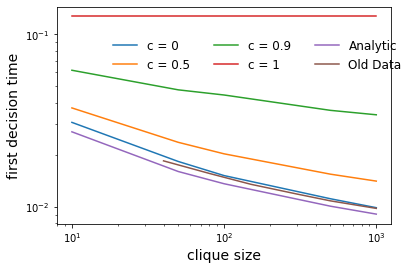

In [6]:



def homoTime(n,th):
    time = th**2/(4*np.log(n))
    return time

# Keep index chooses which values of c_array to display
keepIndex = (0,3,5,6)
for i in keepIndex:
    plt.plot(n_array,timesForC[i], label = "c = " + str(c_array[i]))

    
# Plot analytic solution for homogeneous (c=0) case
homogeneous = [homoTime(n,theta) for n in n_array]
plt.plot(n_array,homogeneous,label = 'Analytic')


# Get homogeneous old data
earlyFolder = "C:/Users/Surface/OneDrive/Documents/MATLAB/Stochastic/Play Time/heterogeny/Ver3Multi/SelfHomo"
thstr = str(theta).replace('.','_')
lateFolder = earlyFolder + '/zMin_' + thstr + '_zMax_' + thstr + '/'
n_array2 = (40,80,150,300,500,1000)
hom = []
for n in n_array2:    
    fileName = lateFolder + 'Cooked_n' + str(n) + '.mat'
    current = sio.loadmat(fileName)
    hom.append(current['avgTime'][0])

plt.plot(n_array2,hom,label = 'Old Data')


# Pretty up graph a little
plt.legend(loc='upper center', bbox_to_anchor=(0.6, .9),
          ncol=3,frameon = False,fontsize = 12)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('clique size',fontsize = 14); plt.ylabel('first decision time', fontsize = 14)
plt.title('average first decision time over ' + str(numTrials) + ' trials' + '\n' + 'threshold = ' + str(theta))

plt.tight_layout()
sns.despine()
saveName = 'avgFDTvsN_' + str(numTrials) + 'trials_th_' + thstr + '.png'
plt.savefig(saveName,dpi = 300)

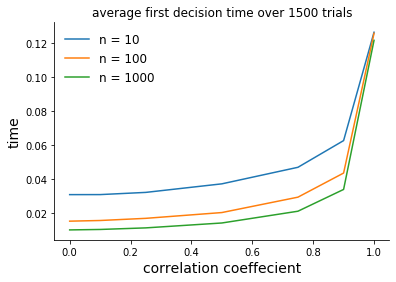

In [150]:
# Average first decision time vs c


# Arrange data
thingsForN = []
for i in range(len(n_array)):
    thisForC = []
    for j in range(len(c_array)):
        thisForC.append(timesForC[j][i])
    thingsForN.append(thisForC)

# Plot things
for i in range(len(n_array)):
    if i%2==0:
        plt.plot(c_array,thingsForN[i], label = "n = " + str(n_array[i]))
    
plt.legend(frameon = False, fontsize = 12)
#plt.yscale('log')
plt.xlabel('correlation coeffecient', fontsize =14); plt.ylabel('time',fontsize = 14)
plt.title('average first decision time over ' + str(numTrials) + ' trials')

sns.despine()
saveName = 'avgFDTvsC_' + str(numTrials) + 'trials.png'
plt.savefig(saveName,dpi = 300)

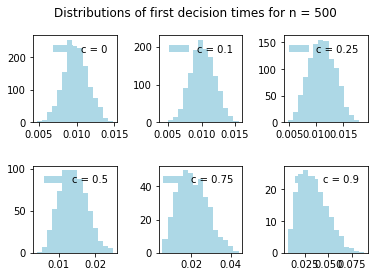

In [153]:
# First decision time distributions

# Which value of n? n_index is index in n_array
n_index = 3

fig, ax = plt.subplots(2,3)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.hist(timeHistsForC[i-1][4],bins = 15,density = True,label = 'c = ' + str(c_array[i-1]),color = 'lightblue')
    plt.legend(frameon = False)
   # plt.tight_layout()
    #plt.xlim(0,.007)
    sns.despine
    
fig.suptitle('Distributions of first decision times for n = ' + str(n_array[n_index]))
saveName = 'pdfFDT_n' + str(n_array[n_index]) +'.png'
plt.savefig(saveName,dpi = 300)

In [155]:
# Track the trajectory of each agent in a 10 agent clique

def oneRunKeepX (n=10,c=.9,th=.1):

    x = np.zeros((n,1)); print(x.shape)
    time = 0
    times = [];times.append(time)
    dt = 5**(-8); #print("Dt = " + str(dt))
    cont = True
    while cont:
        common = np.sqrt(c)*np.random.normal()
        nonCommon = np.sqrt(1-c)*np.random.normal(size=n)
        new = dt + (common + nonCommon)*np.sqrt(2*dt)
        newX = np.zeros((x.shape[0],x.shape[1] + 1)); newX[:,:-1]=x; 
        newX[:,-1] = newX[:,-2] + new
        x = newX
        time = time + dt
        times.append(time)
        if max(abs(x[:,-1])) >= th: cont = False

    FD = x[abs(x) >= th]; #print(FD)
 
    
    if max(FD) > 0: FD = 1 
    else: FD = 0
        
    return(time,FD,x,times)

# Pick n, c, th values
ny = 10; cy = .99; thy = .1;
#tic1 = time.perf_counter()
time,FD,x,times = oneRunKeepX(n = ny, c = cy, th = thy)
#toc1 = time.perf_counter()
#print(tic1-toc1)

(10, 1)


[0, 0.003173546666666954, 0.006347093333333908, 0.009520640000000863]


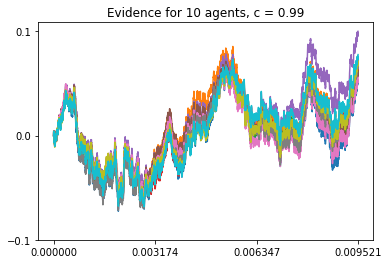

In [160]:
# Plot the individual trajectories.

for i in range(ny):
    plt.plot(times,x[i,:])
plt.title('Evidence for ' + str(ny) + ' agents, c = ' + str(cy))

plt.yticks([-thy,0,thy])
# limit number of xticks
xticks = [0,times[-1]/3,times[-1]*2/3,times[-1]]
print(xticks)
plt.xticks(xticks)

saveName = 'evidencePlot_c_' + str(cy).replace('.','_') +'.png'

plt.savefig(saveName,dpi = 300)

In [21]:
from numba import njit,prange
@njit(parallel = True)

def bakeAllTheCookies(numCookies):

    # We're letting numPerRecipe be a vector of the number of cookies
    # each recipe makes

    cookiesBaked = 0
    for i in prange(len(numCookies)):
        cookiesBaked += numCookies[i]

    return cookiesBaked

In [22]:
numCookies = np.arange(10)

bakeAllTheCookies(numCookies)

45